In [1]:
import os

# username = 'cvillarin'
# username = 'mbalogal'
username = 'jfabrero'
os.environ['XDG_CACHE_HOME'] = f'/home/msds2023/{username}/.cache'
os.environ['HUGGINGFACE_HUB_CACHE'] = f'/home/msds2023/{username}/.cache'

In [2]:
# !git clone https://github.com/stevenstalder/NN-Explainer.git

In [3]:
!cp -r "./NN-Explainer/src/utils" .
!cp -r "./NN-Explainer/src/models" .
!cp ./explainer_salita.py ./models

In [4]:
import torch
import pytorch_lightning as pl

In [5]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification, Wav2Vec2Model
from torch import nn
from torch.optim import Adam
from torchvision import models
from utils.helper import get_targets_from_annotations
from utils.metrics import SingleLabelMetrics
import os

In [6]:
from pathlib import Path
from models.explainer import Deeplabv3Resnet50ExplainerModel
from models.classifier import VGG16ClassifierModel, Resnet50ClassifierModel
from utils.image_utils import save_mask, save_masked_image, save_all_class_masks
from utils.loss import TotalVariationConv, ClassMaskAreaLoss, entropy_loss
import pandas as pd
import torchaudio as ta
from torchaudio import transforms
import sys
from torch.utils.data import DataLoader, Dataset

from pyjanitor import auto_toc
toc = auto_toc()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Dataset and LightningDataModule

In [8]:
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import torch.nn.functional as F

class AudioDataset(Dataset):
    def __init__(self, meta_data, num_frames=160_000):
        self.num_frames = num_frames
        self.meta_data = pd.read_csv(meta_data, header=None, index_col=0)

    def __len__(self):
        return len(self.meta_data)

    def __getitem__(self, index):
        # Edited
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        label_index = self._get_audio_sample_label_index(index)
        signal, sr = ta.load(audio_sample_path, num_frames=self.num_frames)
        transform = transforms.MelSpectrogram(sr, n_mels=40)
        mfcc = transform(signal).squeeze()
        
        return mfcc, label, label_index, signal, audio_sample_path

    def _get_audio_sample_path(self, index):
        path = self.meta_data.iloc[index, 0]
        path = os.path.join(os.getcwd(),path)
        return path

    def _get_audio_sample_label(self, index):
        return self.meta_data.iloc[index, 1]
    
    def _get_audio_sample_label_index(self, index):
        return self.meta_data.iloc[index, 2]
    
class AudioDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=256, num_workers=0, pin_memory=True):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.datasets = {}
        self.dataloaders = {}

    def setup(self, stage=None):
        stages = ['train', 'validation', 'test']

        # Define your datasets
        self.datasets = {
            # Edited
            x: AudioDataset(f'{x}.csv')
            for x in stages
        }

    def pad_sequence(self, batch):
        # Make all tensors in a batch the same length by padding with zeros
        batch = [item.t() for item in batch]
        batch = torch.nn.utils.rnn.pad_sequence(batch,
                                                batch_first=True,
                                                padding_value=0.)
        return batch.permute(0, 2, 1)

    def collate_fn(self, batch):
        tensors, targets, paths = [], [], []

        # Gather tensors and encode labels as indices
        for mel, _, label_index, _, filepath in batch:
            tensors += [mel]
            targets += [torch.tensor(label_index)]
            paths += [filepath]

        # Group the list of tensors into a batched tensor
        tensors = self.pad_sequence(tensors)
        targets = torch.stack(targets)

        return tensors, targets, paths

    def train_dataloader(self):
        return DataLoader(
            self.datasets['train'],
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets['validation'],
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets['test'],
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
        )

# Classifier

In [9]:
class SALITA(pl.LightningModule):
    def __init__(self,
                 num_classes=14,
                 dataset="lang_data",
                 learning_rate=1e-5,
                 metrics_threshold=0.0):
        super().__init__()

        self.setup_model(num_classes)
        self.setup_losses()
        self.setup_metrics(num_classes=num_classes)

        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.dataset = dataset

    def setup_model(self, num_classes):
        self.conv1 = nn.Conv1d(40, 64, kernel_size=3, stride=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, stride=1)
        self.conv5 = nn.Conv1d(512, 1024, kernel_size=3, stride=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1024 * 23, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Load parameters from .pth file
        pretrained_file = "final_model_checkpoint.pth" 
#         pretrained_file = "/mnt/processed/private/msds2023/cpt8/ml3_project/saves/epoch10_model.pth" #Edited
        if os.path.isfile(pretrained_file):
            state_dict = torch.load(pretrained_file)
            self.load_state_dict(state_dict)

    def setup_losses(self):
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)
    
    def setup_metrics(self, num_classes):
        self.train_metrics = SingleLabelMetrics(num_classes=num_classes)
        self.valid_metrics = SingleLabelMetrics(num_classes=num_classes)
        self.test_metrics = SingleLabelMetrics(num_classes=num_classes)

    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        logits = self(x)
        
        preds = torch.argmax(logits, dim=1)
        accuracy = (preds == y).sum().item() / len(y)

        loss = self.loss_fn(logits, y)
        self.log('train_loss', loss)
        self.log('train_accuracy', accuracy)
        self.train_metrics(logits, y)

    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log('val_loss', loss)
        self.valid_metrics(logits, y)
        
    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        accuracy = (preds == y).sum().item() / len(y)

        self.log('test_loss', loss)
        self.log('test_accuracy', accuracy)
        self.test_metrics(logits, y)
        
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

        
    def on_test_epoch_end(self):
        test_metrics = self.test_metrics.compute()
        self.log('test_metrics', test_metrics.compute(), prog_bar=True)
        self.test_metrics.save(model="classifier", classifier_type="SALITA",
                               dataset=self.dataset)
        self.test_metrics.reset()

        # Save the test metrics as instance attributes
        self.test_metrics_results = test_metrics

In [10]:
batch_size = 8

if device.type == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

data_module = AudioDataModule(batch_size=batch_size,
                              num_workers=num_workers,
                              pin_memory=pin_memory)

In [11]:
model = SALITA()
model.to(device)

SALITA(
  (conv1): Conv1d(40, 64, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (conv5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=23552, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=14, bias=True)
  (loss_fn): CrossEntropyLoss()
  (train_metrics): SingleLabelMetrics()
  (valid_metrics): SingleLabelMetrics()
  (test_metrics): SingleLabelMetrics()
)

In [12]:
try:
    model.load_state_dict(torch.load(''))
except:
#     trainer
    pass

# Explainer

In [13]:
from models.explainer_salita import ExplainerClassifierModel

In [14]:
explainer = ExplainerClassifierModel(classifier=model).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
explainer.eval()

ExplainerClassifierModel(
  (explainer): Deeplabv3Resnet50ExplainerModel(
    (explainer): DeepLabV3(
      (backbone): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3

In [16]:
num_classes = 14
# data_base_path = '../../datasets/'
# data_path = Path(data_base_path) / "lang_data"
data_module = AudioDataModule()
data_module.setup(stage = "test")
dataset = "lang_data"
classifier_type = "SALITA"
mode = "seg"

In [17]:
save_path = Path('masks/{}_{}_{}/'.format(dataset, classifier_type, "explainer"))
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# XAI

In [18]:
i2l_dict = {
    0.0: 'HI',
    1.0: 'NE',
    2.0: 'TH',
    3.0: 'SI',
    4.0: 'JA',
    5.0: 'PA',
    6.0: 'AR',
    7.0: 'TA',
    8.0: 'KN',
    9.0: 'FA',
    10.0: 'MY',
    11.0: 'ZH',
    12.0: 'UR',
    13.0: 'ID',
}

l2i_dict = {y: x for x, y in i2l_dict.items()}

In [19]:
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Samples
## Sample 1

In [20]:
audio_sample_path = 'Luffy_cut.wav'
label = 'JA'
label_index = l2i_dict[label]
num_frames = 160_000
n_mels = 40
signal, sr = ta.load(audio_sample_path, num_frames=num_frames)
transform = transforms.MelSpectrogram(sr, n_mels=n_mels)
mfcc = transform(signal).squeeze()


x = mfcc.repeat(3, 1, 1)
x = x.to(device)
y = torch.tensor(label_index).to(device)
filename = audio_sample_path.rsplit('/', 1)[-1]

_, _, mask, _, _ = explainer(x, y)
predict = explainer.classifier(x)

In [21]:
def plot_waveform(waveform, sr, num_frames, title="Waveform"):
    waveform = waveform.numpy()
    n_channels, n_frames = waveform.shape
    if n_channels > 1:
        waveform = waveform[:1]
    
    if n_frames > num_frames:
        padded = waveform[:,:num_frames]
    else:
        padded = np.zeros((1, num_frames))
        padded[:, :num_frames] = waveform
        
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(1, 1, figsize=(15, 6))
    axes.plot(time_axis, padded[0], linewidth=1, c='k')
    axes.axis('off')
    figure.suptitle(title)
    plt.show(block=False)
    
    return padded

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.heatmap(torch.log(x.view(40, 801, -1)[:, :, 0]+1e-3).cpu(),
            cmap='PuRd',
            cbar=False,
            ax=ax[0])
sns.heatmap(mask.view(40, 801, -1)[:, :, 0].cpu(),
            cmap='gray',
            cbar=False,
            ax=ax[1])
ax[0].axis('off')
ax[0].set_title('MFCC of the Sample Audio File')
ax[1].axis('off')
ax[1].set_title('Saliency Mask of the Sample Audio File')
toc.add_fig('MFCC Representation - Sample', width=100)

In [23]:
from skimage.morphology import erosion, dilation, opening, closing
def erode(image, selem, n=1):
    """Perform erosion `n` times"""
    for _ in range(n):
        image = erosion(image, selem)
    
    return image


def dilate(image, selem, n=1):
    """Perform dilation `n` times"""
    for _ in range(n):
        image = dilation(image, selem)
    
    return image


def n_close(image, selem, n=1):
    """Perform dilation `n` times"""
    for _ in range(n):
        image = closing(image, selem)
    
    return image


def n_open(image, selem, n=1):
    """Perform dilation `n` times"""
    for _ in range(n):
        image = opening(image, selem)
    
    return image


def plot_waveform(waveform, sr, num_frames, title="Waveform"):
    waveform = waveform.numpy()
    n_channels, n_frames = waveform.shape
    if n_channels > 1:
        waveform = waveform[:1]
    
    if n_frames > num_frames:
        padded = waveform[:,:num_frames]
    else:
        padded = np.zeros((1, num_frames))
        padded[:, :num_frames] = waveform
        
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(1, 1, figsize=(15, 6))
    axes.plot(time_axis, padded[0], linewidth=1, c='k')
    axes.axis('off')
    figure.suptitle(title)
    plt.show(block=False)
    
    return padded


def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

In [24]:
waveform, sr = ta.load(audio_sample_path)
plot_mask = mask + mask.min()
plot_mask = (plot_mask.sum(1) / plot_mask.sum(1).max()).mean(0)
thick_mask = (plot_mask > plot_mask.quantile(.75)).float()
wave_mask = plot_mask[:-1].view(1, -1).t().repeat(1, 200).view(1, -1).cpu().numpy()

closed_mask = erode(thick_mask.repeat(3, 1).cpu().numpy(),
                      np.array([[0,0,0],
                                [1,1,1],
                                [0,0,0]]),
                      5)
closed_mask = dilate(closed_mask,
                      np.array([[0,0,0],
                                [1,1,1],
                                [0,0,0]]),
                      5)
closed_mask = n_close(closed_mask,
                      np.array([[0,0,0],
                                [1,1,1],
                                [0,0,0]]),
                      5)

wave_top_mask = np.repeat(closed_mask[0, :-1].reshape(1, -1).T, 200, 1).reshape(1, -1)

NameError: name 'padded_waveform' is not defined

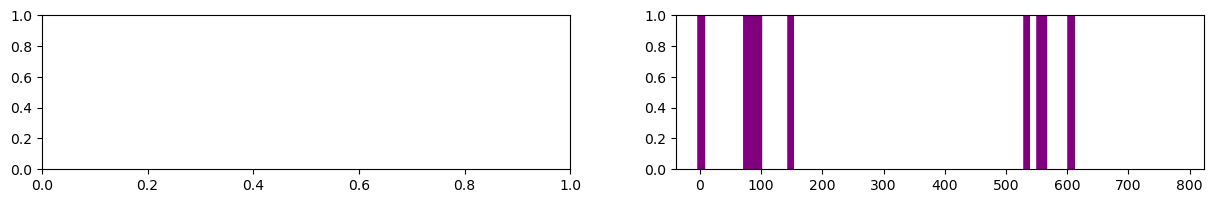

In [25]:
c1='white'
c2='purple'
n=801
    
fig, ax = plt.subplots(1, 2, figsize=(15, 2))
for i in range(n):
    ax[1].axvline(i, color=colorFader(c1,c2,closed_mask[0, i]), linewidth=4)

time_axis = torch.arange(0, 160_000) / 200

for ai in ax:
    ai.plot(time_axis, padded_waveform[0], linewidth=1, c='k')
    ai.axis('off')

ax[0].set_title('Original Waveform')
ax[1].set_title('Waveform with Importance Gradients')
toc.add_fig('Sample Timestep Importance Identification', width=100)

# Original Audio

In [ ]:
from IPython.display import Audio
Audio(padded_waveform, rate=sr)

# Mask Audio

In [ ]:
Audio(padded_waveform*wave_top_mask, rate=sr)